In [1]:
import jieba
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re
import os

# 设置中文显示参数
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==================== 模型配置 ====================
CORPUS_PATH = r"C:\Users\30507\Desktop\DL-NLP-2025-LSX-main\hw2\data\三十三剑客图.txt"
VEC_DIM = 100
HIDDEN_SIZE = 128
BATCH_SIZE = 64
WINDOW_SIZE = 5  # 序列窗口
TRAIN_EPOCHS = 30
MIN_COUNT = 5    # 最小词频

# ==================== 数据准备 ====================
class SequenceDataset(Dataset):  # 原TextDataset
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        input_seq = torch.LongTensor(self.samples[index][:-1])
        target = torch.LongTensor([self.samples[index][-1]])
        return input_seq, target

def prepare_text_data(file_path):
    # 读取并清洗文本
    with open(file_path, 'r', encoding='gb18030') as file:
        text = re.sub(r'\s+', '', file.read())  # 移除空白
    
    # 分词处理
    terms = list(jieba.cut(text))
    
    # 构建词汇映射
    term_frequency = {}
    for term in terms:
        term_frequency[term] = term_frequency.get(term, 0) + 1
    
    word_to_id = {'<PAD>':0, '<UNK>':1}
    current_id = 2
    for term, freq in term_frequency.items():
        if freq >= MIN_COUNT:
            word_to_id[term] = current_id
            current_id += 1
    
    # 生成训练样本
    training_samples = []
    for pos in range(len(terms)-WINDOW_SIZE):
        sample = [word_to_id.get(term, 1) for term in terms[pos:pos+WINDOW_SIZE+1]]
        training_samples.append(sample)
    
    return word_to_id, training_samples

# ==================== 网络结构 ====================
class LanguageModelLSTM(nn.Module):  # 原LSTMLM
    def __init__(self, vocab_size):
        super().__init__()
        self.term_embedding = nn.Embedding(vocab_size, VEC_DIM)
        self.lstm_layer = nn.LSTM(VEC_DIM, HIDDEN_SIZE, batch_first=True)
        self.output_layer = nn.Linear(HIDDEN_SIZE, vocab_size)
        
    def forward(self, input_seq):
        embedded_input = self.term_embedding(input_seq)
        lstm_output, _ = self.lstm_layer(embedded_input)
        predictions = self.output_layer(lstm_output[:, -1, :])
        return predictions

# ==================== 模型训练 ====================
def train_language_model(vocabulary, training_data):
    dataset = SequenceDataset(training_data)
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    model = LanguageModelLSTM(len(vocabulary))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    for epoch in range(TRAIN_EPOCHS):
        epoch_loss = 0.0
        for inputs, targets in data_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets.squeeze())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{TRAIN_EPOCHS}, Loss: {epoch_loss/len(data_loader):.4f}")
    
    return model

# ==================== 分析工具 ====================
class EmbeddingInspector:  # 原VectorAnalyzer
    def __init__(self, trained_model, vocabulary):
        self.embedding_matrix = trained_model.term_embedding.weight.data
        self.id_to_term = {v:k for k,v in vocabulary.items()}
        self.term_to_id = vocabulary
        
    def get_similar_terms(self, query_term, top_k=5):
        if query_term not in self.term_to_id:
            return []
        query_id = self.term_to_id[query_term]
        query_vector = self.embedding_matrix[query_id].numpy()
        
        similarity_scores = []
        for idx, vector in enumerate(self.embedding_matrix):
            if idx == query_id: continue
            score = cosine_similarity([query_vector], [vector.numpy()])[0][0]
            similarity_scores.append((self.id_to_term[idx], score))
        return sorted(similarity_scores, key=lambda x: -x[1])[:top_k]
    
    def visualize_word_clusters(self, terms, cluster_num=2):
        vectors = []
        valid_terms = []
        for term in terms:
            if term in self.term_to_id:
                vectors.append(self.embedding_matrix[self.term_to_id[term]].numpy())
                valid_terms.append(term)
        
        # 降维处理
        pca = PCA(n_components=2)
        low_dim_vectors = pca.fit_transform(vectors)
        
        # 聚类分析
        os.environ["OMP_NUM_THREADS"] = "1"  # 避免警告
        cluster_model = KMeans(n_clusters=cluster_num, n_init=10).fit(low_dim_vectors)
        
        # 可视化展示
        plt.figure(figsize=(10,6))
        plt.scatter(low_dim_vectors[:,0], low_dim_vectors[:,1], c=cluster_model.labels_)
        for idx, term in enumerate(valid_terms):
            plt.annotate(term, (low_dim_vectors[idx,0], low_dim_vectors[idx,1]))
        plt.title("词语聚类可视化")
        plt.show()
    
    def calculate_text_similarity(self, text1, text2):
        def _get_text_vector(text):
            terms = jieba.lcut(text)
            vectors = []
            for term in terms:
                if term in self.term_to_id:
                    vectors.append(self.embedding_matrix[self.term_to_id[term]].numpy())
            return np.mean(vectors, axis=0) if vectors else np.zeros(VEC_DIM)
        
        vec1 = _get_text_vector(text1)
        vec2 = _get_text_vector(text2)
        return cosine_similarity([vec1], [vec2])[0][0]

In [3]:
vocab, sequences = prepare_text_data(CORPUS_PATH)
print(f"词汇表大小: {len(vocab)}")

# 训练模型
embeddings = train_language_model(vocab, sequences)

# 初始化验证器
validator = EmbeddingInspector(embeddings, vocab)

词汇表大小: 1002
Epoch 1/30, Loss: 3.9341
Epoch 2/30, Loss: 3.6077
Epoch 3/30, Loss: 3.4636
Epoch 4/30, Loss: 3.3417
Epoch 5/30, Loss: 3.2302
Epoch 6/30, Loss: 3.1266
Epoch 7/30, Loss: 3.0265
Epoch 8/30, Loss: 2.9294
Epoch 9/30, Loss: 2.8308
Epoch 10/30, Loss: 2.7349
Epoch 11/30, Loss: 2.6362
Epoch 12/30, Loss: 2.5409
Epoch 13/30, Loss: 2.4442
Epoch 14/30, Loss: 2.3486
Epoch 15/30, Loss: 2.2564
Epoch 16/30, Loss: 2.1673
Epoch 17/30, Loss: 2.0789
Epoch 18/30, Loss: 1.9934
Epoch 19/30, Loss: 1.9099
Epoch 20/30, Loss: 1.8281
Epoch 21/30, Loss: 1.7515
Epoch 22/30, Loss: 1.6770
Epoch 23/30, Loss: 1.6055
Epoch 24/30, Loss: 1.5358
Epoch 25/30, Loss: 1.4696
Epoch 26/30, Loss: 1.4063
Epoch 27/30, Loss: 1.3459
Epoch 28/30, Loss: 1.2898
Epoch 29/30, Loss: 1.2349
Epoch 30/30, Loss: 1.1798



【剑客】相似词:
[('一个', np.float32(0.33815187)), ('说起', np.float32(0.2694875)), ('大', np.float32(0.2619967)), ('小说', np.float32(0.25647476)), ('所以', np.float32(0.24934989))]

聚类可视化:


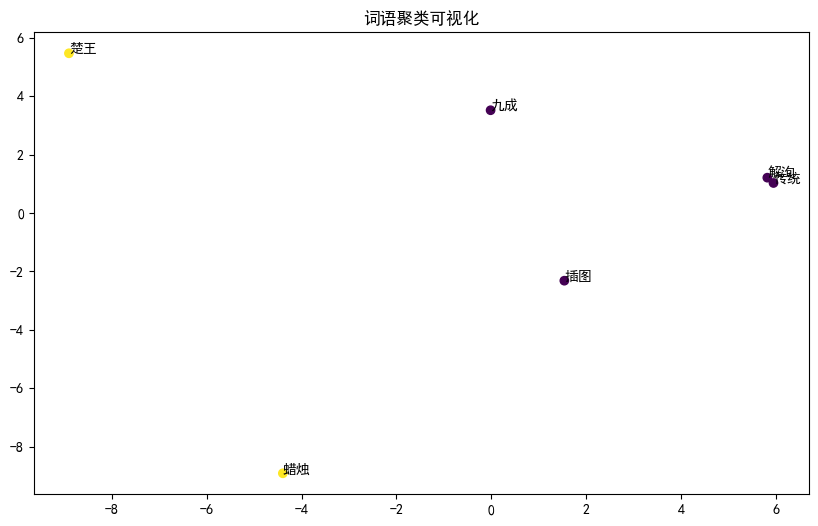


段落相似度: 0.4315


In [4]:
print("\n【剑客】相似词:")
print(validator.get_similar_terms('剑客'))

print("\n聚类可视化:")
validator.visualize_word_clusters(['传统', '插图', '蜡烛', '楚王', '解洵', "九成"])

para1 = "旧小说有插图和绣像，是我国向来的传统。"
para2 = "江苏与浙江到宋朝时已渐渐成为中国的经济与文化中心，苏州、杭州成为出产文化和美女的地方。"
print(f"\n段落相似度: {validator.calculate_text_similarity(para1, para2):.4f}")